<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/05_measuring_problem_radius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **🚀 Setting up the environment**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
import time
import concurrent.futures
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from collections import Counter
from torch_geometric.utils import to_dense_adj
from tqdm.notebook import tqdm

%matplotlib inline
sns.set_style('darkgrid')

## **🧰 Utility functions**

In [3]:
def get_k_hop_neighborhood(k:int, adj: torch.tensor) -> list:
    """Returns the list of k-hop dense adjacency matrices
    
    Args:
        - k (int): maximum depth of neighborhood to compute
        - adj [num_nodes, num_nodes]: dense adjacency matrix
    
    :rtype: List[torch.Tensor]
    """
    
    k_hop_neb = [adj.clone()]
    pow_A = adj.clone()

    for l in tqdm(range(k-1)):
        pow_A = torch.mm(adj, pow_A)
        k_neb = torch.where(
            torch.where(pow_A > 0, 1, 0) - sum(k_hop_neb) > 0,
            1,
            0
        )
        k_hop_neb.append(k_neb)
    
    return k_hop_neb

In [4]:
def scale(X:torch.Tensor):
    """Returns the scaled features of the graph

    Args:
        - X [num_nodes, num_features]
    """
   
    m = torch.mean(X, dim=0)
    s = torch.std(X, dim=0)
    ones = torch.ones(s.shape)
    s = torch.where(s == 0, ones, s)
    return (X - m)/ s

In [5]:
def centroids(X:torch.Tensor, y:torch.Tensor):
    """Returns the label representation by averaging its nodes' features

    Args:
        - X [num_nodes, num_features]: node features
        - y [num_nodes]: labels
    """
    
    # group nodes by label
    obs = {}
    for i in range(X.size(0)):
        if obs.get(y[i].item()):
            obs[y[i].item()] += [X[i]]
        else:
            obs[y[i].item()] = [X[i]]

    avg_obs = [ sum(obs[c]) / len(obs[c]) for c in range(7) ]
    
    # convert to torch tensor
    return torch.tensor(list(map(lambda x: x.numpy(), avg_obs)))

In [ ]:
def feature_correlation(all_adj, X, centroids, k):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.

    Args:
        - all_adj: list of k-hop adjacency dense matrices [num_nodes, num_nodes]
        - X: [num_nodes, num_features] features
        - centroids: [num_classes, num_features]
        - k (int): depth of the neighborhood

    :rtype: list - [num_nodes]
    """

    return [np.mean(np.absolute(np.corrcoef(
                x=X[ sum(all_adj[:k])[i] == 1 ].numpy(),
                # x=X[ all_adj[k-1][i] == 1 ].numpy(), # k-hop only
                y=centroids[G.y[i].item()].numpy()
            )[:-1, -1])) if (all_adj[k-1][i] == 1).sum() > 0 else 0
            for i in tqdm(range(X.size(0)))]

In [6]:
def homophily_index(neb:torch.tensor, mask=None):
    """Computes the homophily index for a given depth

    Args:
        - neb [num_nodes, num_nodes]: neighbors to consider (can be the adjacency matrix or k-hop neighborhood)
        - mask [num_nodes]: "train", "test" or "val" to consider only these specific neighbors
    """
    
    if mask == None:
        mask = torch.ones(G.num_nodes)

    # neb_labels = G.y[neb[i] * mask == 1] # looking at the labels of the neighbors (within the mask)
    # if len(neb_labels) == 0: return 0
    # return (labels == G.y[i]).sum().item() / len(labels)
    
    return np.mean([(G.y[neb[i] * mask == 1] == G.y[i]).float().mean().item() if (neb[i] * mask == 1).sum() > 0 else 0 for i in range(G.num_nodes)])

In [ ]:
homophily_index(to_dense_adj(G.edge_index).squeeze(0), G.train_mask)

0.8251578295204453

In [7]:
def corrcoef(x:torch.Tensor, y:torch.Tensor):
    """Mimics `np.corrcoef`

    Args
        - x: 2D torch.Tensor
        - y: 1D torch.Tensor
    
    Returns
        c : torch.Tensor
            if x.size() = (5, 100), then return val will be of size (5,5)

    -------
    Numpy docs ref:
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
    Numpy code ref: 
        https://github.com/numpy/numpy/blob/v1.12.0/numpy/lib/function_base.py#L2933-L3013

    Example:
        >>> x = np.random.randn(5,120)
        # result is a (5,5) matrix of correlations between rows
        >>> np_corr = np.corrcoef(x)
        >>> th_corr = corrcoef(torch.from_numpy(x))
        >>> np.allclose(np_corr, th_corr.numpy())
        # [out]: True
    """
    if x == []: return torch.tensor(0.)

    # calculate covariance matrix of rows
    mean_x = x.mean(1).unsqueeze(1).expand(x.shape) # [num_nodes]
    mean_y = y.mean()                               # (1)
    
    c = torch.matmul((x - mean_x), (y - mean_y).t()) / y.size(0) # covariance

    # normalize covariances
    std_x = torch.std(x, dim=1)
    std_y = torch.std(y)

    c = c / (std_x * std_y)
    
    # clamp between -1 and 1
    # probably not necessary but numpy does it
    c = torch.clamp(c, -1.0, 1.0)

    return c

In [8]:
def graph_correlation(neb, x, y):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.

    Args:
        - neb [num_nodes, num_nodes]: dense adjacency matrix
        - x [num_nodes, num_features]: node features
        - y [num_nodes, num_features]: label representation associated with the target node

    :rtype: list - [num_nodes]
    """

    num_nodes = x.size(0)
    return [corrcoef(x=x[neb[i] == 1], y=y[i]).abs().mean() for i in tqdm(range(num_nodes))]

In [ ]:
def opt_feature_correlation(all_adj, X, centroids, k):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.

    Args:
        - all_adj: list of k-hop adjacency dense matrices [num_nodes, num_nodes]
        - X: [num_nodes, num_features] features
        - centroids: [num_classes, num_features]
        - k (int): depth of the neighborhood

    :rtype: list - [num_nodes]
    """

    return [corrcoef(
        x=X[ sum(all_adj[:k])[i] == 1 ],
        y=centroids[ G.y[i].item() ]
    ).abs().mean() if (sum(all_adj[:k])[i] == 1).sum() > 0 else 0
    for i in tqdm(range(X.size(0)))]

In [ ]:
# put it all into a function
def fast_graph_correlation(neb, x, y):
    """Computes the average feature correlation over all the nodes of the graph

    Args:
        - neb [num_nodes, num_nodes]: dense adjacency matrix
        - x [num_nodes, num_features]: node features
        - y [num_nodes, num_features]: label representation associated with the target node
    """

    correlations = []
    num_nodes = x.size(0)
    k = 5

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = [executor.submit(corrcoef, x=x[neb[i] == 1], y=y[i]) for i in range(num_nodes)]

        for f in concurrent.futures.as_completed(results):
            correlations.append(f.result().abs().mean())
        
    return correlations

## **🧪 Test with different datasets**

In [9]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset

path = osp.join(os.getcwd(), 'data')

### **📰 Cora (short-range)**

In [10]:
# cora dataset
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

Processing...
Done!


In [11]:
all_neb = get_k_hop_neighborhood(20, to_dense_adj(G.edge_index).squeeze(0))

  0%|          | 0/19 [00:00<?, ?it/s]

In [12]:
avg_obs = centroids(G.x, G.y)

In [ ]:
k_hop_correlations = [np.mean(feature_correlation(all_neb, G.x, avg_obs, k=k)) for k in tqdm(range(1, 21))]

  0%|          | 0/20 [00:00<?, ?it/s]

[Text(0, 0.5, 'Correlation'), Text(0.5, 0, 'Neighborhood depth')]

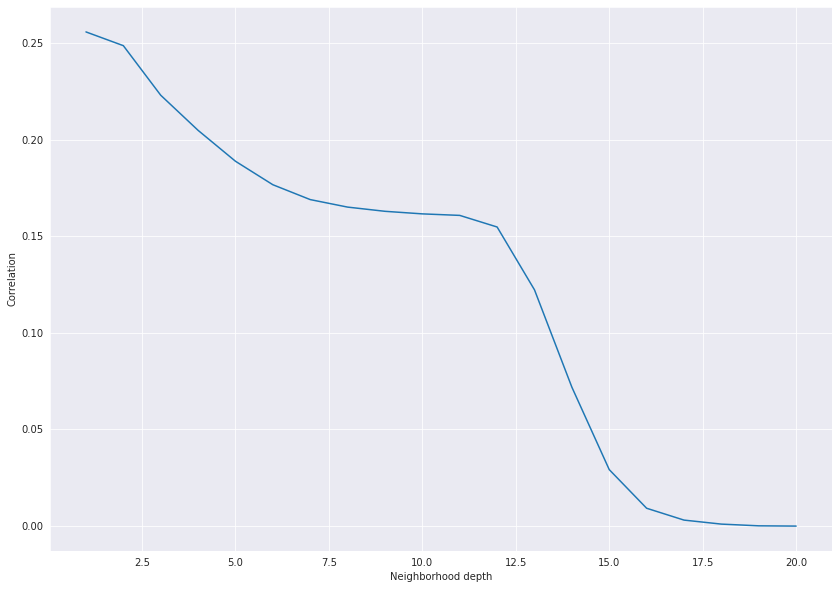

In [ ]:
plt.figure(figsize=(14, 10))
sns.lineplot(x=range(1, 21), y=k_hop_correlations).set(xlabel="Neighborhood depth", ylabel="Correlation")

In [13]:
y = torch.stack([avg_obs[G.y[i].item()] for i in range(G.num_nodes)])

In [14]:
k_hop_correlations = [np.mean(graph_correlation(sum(all_neb[:k]), x=G.x, y=y)) for k in tqdm(range(1, 21))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

[Text(0, 0.5, 'Correlation'), Text(0.5, 0, 'Neighborhood depth')]

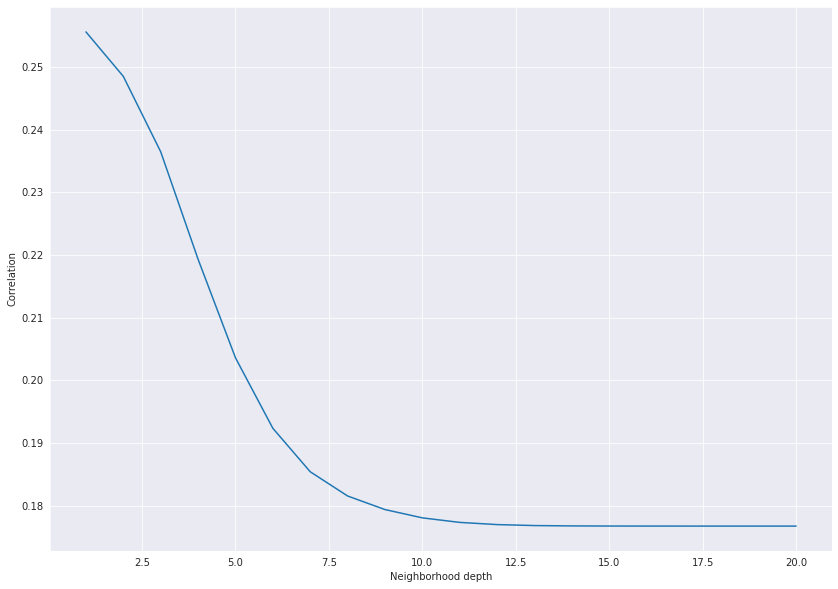

In [15]:
plt.figure(figsize=(14, 10))
sns.lineplot(x=range(1, 21), y=k_hop_correlations).set(xlabel="Neighborhood depth", ylabel="Correlation")

#### **Compute feature correlation on scaled features**

In [12]:
X_scaled = scale(G.x)
scaled_centroids = centroids(X_scaled, G.y)
y_scaled = torch.stack([scaled_centroids[G.y[i].item()] for i in range(G.num_nodes)])

In [13]:
k_hop_correlations = [np.mean(graph_correlation(sum(all_neb[:k]), x=X_scaled, y=y_scaled)) for k in tqdm(range(1, 21))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

[Text(0, 0.5, 'Correlation'),
 Text(0.5, 0, 'Neighborhood depth'),
 Text(0.5, 1.0, 'Scaled Features Correlation')]

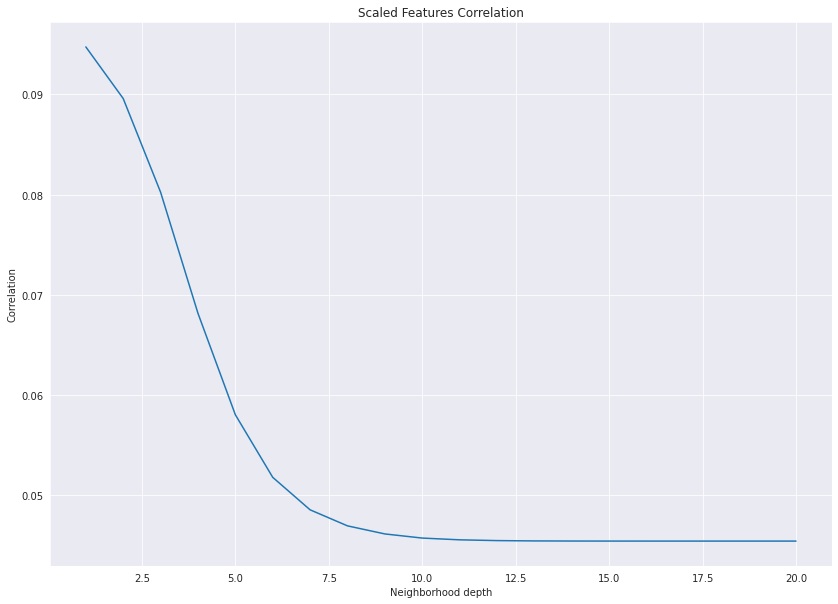

In [14]:
plt.figure(figsize=(14, 10))
sns.lineplot(x=range(1, 21), y=k_hop_correlations).set(title="Scaled Features Correlation", xlabel="Neighborhood depth", ylabel="Correlation")

### **⚛ QM9 (long-range)**

In [ ]:
# amazon dataset
qm9 = load_dataset(path, 'QM9')